# 3.2 DataLoader 작성

- PSPNet 시맨틱 분할용의 Dataset과 DataLoader를 작성합니다. VOC2012 데이터 세트를 대상으로 합니다.


# 학습 목표

1.  시맨틱 분할에 사용하는 Dataset, DataLoader 클래스를 만들 수 있다
2.  PSPNet의 전처리 및 데이터 확장의 처리 내용을 이해한다

# 사전 준비

- 도서의 지시에 따라, 이 장에서 사용하는 데이터를 다운로드합니다.


In [1]:
# 패키지 import
import os.path as osp
from PIL import Image

import torch.utils.data as data

# 화상 데이터, 어노테이션 데이터 파일의 경로 리스트 작성

In [2]:
def make_datapath_list(rootpath):
    """
    학습, 검증용 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다.

    Parameters
    ----------
    rootpath : str
        데이터 폴더의 경로

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터의 경로를 저장한 리스트
    """

    # 화상 파일과 어노테이션 파일의 경로 템플릿을 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')

    # 훈련 및 검증 파일 각각의 ID(파일 이름)를 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 훈련 데이터의 화상 파일과 어노테이션 파일의 경로 리스트를 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 공백과 줄바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상의 경로
        anno_path = (annopath_template % file_id)  # 어노테이션의 경로
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 검증 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상의 경로
        anno_path = (annopath_template % file_id)  # 어노테이션의 경로
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [3]:
# 동작 확인: 파일 경로 리스트를 취득
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

print(train_img_list[0])
print(train_anno_list[0])


./data/VOCdevkit/VOC2012/JPEGImages\2007_000032.jpg
./data/VOCdevkit/VOC2012/SegmentationClass\2007_000032.png


# Dataset 작성

In [4]:
# 데이터 처리 클래스와 데이터 확장 클래스를 import
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor

class DataTransform():
    """
    화상과 어노테이션의 전처리 클래스. 훈련시와 검증시 다르게 동작한다.
    화상의 크기를 input_size x input_size로 한다.
    훈련시에 데이터 확장을 수행한다.

    Attributes
    ----------
    input_size : int
        리사이즈 대상 화상의 크기.
    color_mean : (R, G, B)
        각 색상 채널의 평균값.
    color_std : (R, G, B)
        각 색상 채널의 표준편차.
    """

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),  # 화상의 확대
                RandomRotation(angle=[-10, 10]),  # 회전
                RandomMirror(),  # 랜덤 미러
                Resize(input_size),  # 리사이즈(input_size)
                Normalize_Tensor(color_mean, color_std)  # 색상 정보의 표준화와 텐서화
            ]),
            'val': Compose([
                Resize(input_size),  # 리사이즈(input_size)
                Normalize_Tensor(color_mean, color_std)  # 색상 정보의 표준화와 텐서화
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드를 지정.
        """
        return self.data_transform[phase](img, anno_class_img)


In [6]:
class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. PyTorch의 Dataset 클래스를 상속받는다.

    Attributes
    ----------
    img_list : 리스트
        어노테이션의 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션의 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련을 설정한다.
    transform : object
        전처리 클래스의 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''화상의 매수를 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리한 화상의 텐서 형식 데이터와 어노테이션을 취득
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        '''화상의 텐서 형식 데이터, 어노테이션을 취득한다'''

        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)   # [높이][폭][색RGB]

        # 2. 어노테이션 화상 읽기
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [높이][폭]

        # 3. 전처리 실시
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img


In [7]:
# 동작 확인

# (RGB) 색의 평균치와 표준편차
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# 데이터 세트 작성
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# 데이터를 추출하는 예
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0))


torch.Size([3, 475, 475])
torch.Size([475, 475])
(tensor([[[ 1.6667,  1.5125,  1.5639,  ...,  1.7523,  1.6667,  1.7009],
         [ 1.5810,  1.4269,  1.4783,  ...,  1.7009,  1.6153,  1.6495],
         [ 1.5639,  1.4098,  1.4440,  ...,  1.6838,  1.5982,  1.6324],
         ...,
         [-0.4739, -0.4911, -0.5424,  ...,  1.2557,  1.1872,  1.2214],
         [-0.5596, -0.4911, -0.4911,  ...,  1.2385,  1.1872,  1.2214],
         [-0.6281, -0.3883, -0.3369,  ...,  1.2385,  1.1872,  1.2214]],

        [[ 1.8333,  1.6758,  1.7283,  ...,  1.9209,  1.8333,  1.8683],
         [ 1.7458,  1.5882,  1.6408,  ...,  1.8683,  1.7808,  1.8158],
         [ 1.7283,  1.5707,  1.6057,  ...,  1.8508,  1.7633,  1.7983],
         ...,
         [-0.5826, -0.6001, -0.6527,  ...,  1.4132,  1.3431,  1.3431],
         [-0.6702, -0.6001, -0.6001,  ...,  1.3957,  1.3431,  1.3431],
         [-0.7402, -0.4951, -0.4426,  ...,  1.3957,  1.3431,  1.3431]],

        [[ 2.0474,  1.8905,  1.9428,  ...,  2.1346,  2.0474,  2.08

# DataLoader 작성

In [8]:
# 데이터 로더 작성
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전 오브젝트로 정리한다
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["val"])  # 반복자로 변환
imges, anno_class_imges = next(batch_iterator)  # 첫번째 요소를 꺼낸다
print(imges.size())  # torch.Size([8, 3, 475, 475])
print(anno_class_imges.size())  # torch.Size([8, 3, 475, 475])


torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


끝

# (부록) Dataset에서 화상을 추출해 화면에 그리기

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## 훈련용 화상을 화면에 그리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


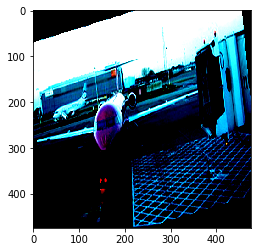

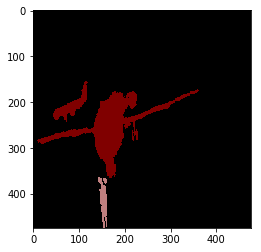

In [10]:
# 실행할 때마다 바뀝니다

# 화상 데이터 읽기
index = 0
imges, anno_class_imges = train_dataset.__getitem__(index)

# 화상 표시
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# 어노테이션 화상 표시
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [높이][폭][색RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()


## 검증용 화상을 화면에 그리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


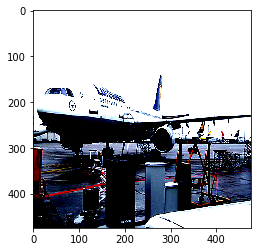

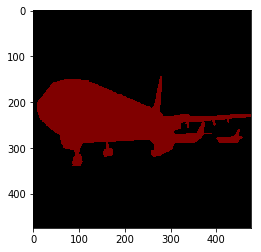

In [11]:
# 화상 데이터 읽기
index = 0
imges, anno_class_imges = val_dataset.__getitem__(index)

# 화상 표시
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# 어노테이션 화상 표시
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [높이][폭][색RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()


끝